# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [1]:

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")



In [2]:
df = pd.read_csv(r'C:\Users\User\Documents\ML notes\Kaggle\data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [3]:

# by default majority class (benign) will be negative
lb = LabelBinarizer()
df['diagnosis'] = lb.fit_transform(df['diagnosis'].values)
targets = df['diagnosis']
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df, targets, stratify=targets)

In [5]:
# show the distribution
print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0    0.626761
1    0.373239
Name: diagnosis, dtype: float64
y_test class distribution
0    0.629371
1    0.370629
Name: diagnosis, dtype: float64


## First strategy: Optimize for sensitivity using GridSearchCV with the scoring argument.
First build a generic classifier and setup a parameter grid; random forests have many tunable parameters, which make it suitable for GridSearchCV. The scorers dictionary can be used as the scoring argument in GridSearchCV. When multiple scores are passed, GridSearchCV.cv_results_ will return scoring metrics for each of the score types provided.

In [6]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

The function below uses GridSearchCV to fit several classifiers according to the combinations of parameters in the param_grid. The scores from scorers are recorded and the best model (as scored by the refit argument) will be selected and "refit" to the full training data for downstream use. This also makes predictions on the held out X_test and prints the confusion matrix to show performance.

The point of the wrapper function is to quickly reuse the code to fit the best classifier according to the type of scoring metric chosen. First, try precision_score, which should limit the number of false positives. This isn't well-suited for the goal of maxium sensitivity, but allows us to quickly show the difference between a classifier optimized for precision_score and one optimized for recall_score.

In [7]:
def grid_search_wrapper(refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    
 # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search


In [8]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 25, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        85         5
pos         1        52


#### The precision, recall, and accuracy scores for every combination of the parameters in param_grid are stored in cv_results_. Here, a pandas DataFrame helps visualize the scores and parameters for each classifier iteration. This is included to show that although accuracy may be relatively consistent across classifiers, it’s obvious that precision and recall have a trade-off. Sorting by precision, the best scoring model should be the first record. This can be checked by looking at the parameters of the first record and comparing them to grid_search.best_params_ above.

In [9]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)

In [10]:
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
90,0.959,0.938,0.960,25,20,3,100
84,0.958,0.931,0.958,25,10,3,100
92,0.958,0.937,0.960,25,20,5,100
24,0.958,0.924,0.956,5,3,3,100
36,0.958,0.931,0.958,5,10,3,100


#### That classifier was optimized for precision. For comparison, to show how GridSearchCV selects the best classifier, the function call below returns a classifier optimized for recall. The grid might be similar to the grid above, the only difference is that the classifer with the highest recall will be refit. This will be the most desirable metric in the cancer diagnosis classification problem, there should be less false negatives on the test set confusion matrix.

In [11]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 15, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg        88         2
pos         1        52


In [12]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)

In [13]:
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
37,0.964,0.931,0.960,5,10,3,300
85,0.963,0.931,0.960,25,10,3,300
56,0.963,0.944,0.965,15,5,5,100
64,0.963,0.925,0.958,15,10,10,100
60,0.963,0.918,0.956,15,10,3,100


## Strategy 2: Adjust the decision threshold to identify the operating point
The precision_recall_curve and roc_curve are useful tools to visualize the sensitivity-specificty tradeoff in the classifier. They help inform a data scientist where to set the decision threshold of the model to maximize either sensitivity or specificity. This is called the “operating point” of the model.

The key to understanding how to fine tune classifiers in scikit-learn is to understand the methods.predict_proba() and .decision_function(). These return the raw probability that a sample is predicted to be in a class. This is an important distinction from the absolute class predictions returned by calling the .predict() method.

To make this method generalizable to all classifiers in scikit-learn, know that some classifiers (like RandomForest) use .predict_proba() while others (like SVC) use .decision_function(). The default threshold for RandomForestClassifier is 0.5, so use that as a starting point. Create an array of the class probabilites called y_scores.

In [61]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]  # Probability of X_test being 1
y_scores

array([0.025     , 0.0125    , 0.5447381 , 0.17934921, 0.01      ,
       0.156     , 0.69456349, 0.        , 0.07      , 0.        ,
       1.        , 0.01      , 0.15452381, 0.05385714, 0.005     ,
       0.        , 0.995     , 0.99333333, 0.95716667, 1.        ,
       0.        , 0.0125    , 0.32264286, 0.12616667, 0.95333333,
       0.995     , 0.        , 0.02166667, 0.95016667, 0.39859524,
       0.        , 0.168     , 0.        , 0.0265    , 0.952     ,
       0.01      , 0.46994444, 0.        , 1.        , 0.995     ,
       0.97      , 1.        , 0.025     , 0.58861111, 1.        ,
       0.16319048, 1.        , 0.0989127 , 0.99333333, 0.006     ,
       1.        , 1.        , 0.01      , 0.        , 0.01      ,
       0.02      , 0.943     , 0.28457143, 0.005     , 0.58183333,
       0.        , 0.005     , 0.99833333, 0.93716667, 0.52047619,
       0.01      , 1.        , 0.        , 0.79783333, 0.        ,
       1.        , 0.0125    , 0.0325    , 0.12414286, 0.04569

In [62]:
#y_scores = grid_search_clf.predict_proba(X_test) # Provides array of probabilites of X_test being 0 & 1. 

In [63]:
# for classifiers with decision_function, this achieves similar results
#y_scores = classifier.decision_function(X_test)

## Generate the precision-recall curve for the classifier:

In [96]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

#### Here adjusted_classes is a simple function to return a modified version of y_scores that was calculated above, only now class labels will be assigned according to the probability threshold t. The other function below plots the precision and recall with respect to the given threshold value, t.

In [97]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

#### Re-execute this function for several iterations, changing t each time, to tune the threshold until there are 0 False Negatives. On this particular run, I had to go all the way down to 0.29 before reducing the false negatives to 0.

     pred_neg  pred_pos
neg        88         2
pos         0        53


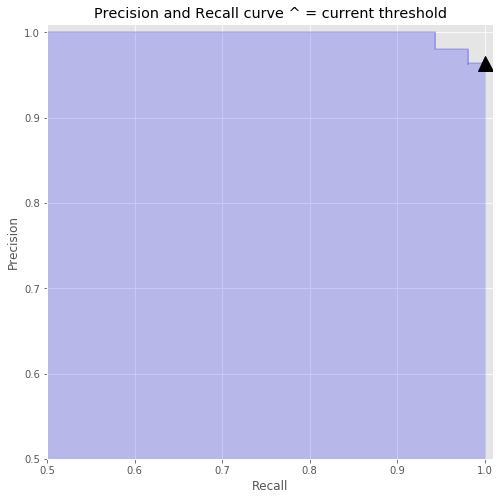

In [98]:
precision_recall_threshold(p, r, thresholds, 0.49)

## Another way to view the trade off between precision and recall is to plot them together as a function of the decision threshold.


In [99]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

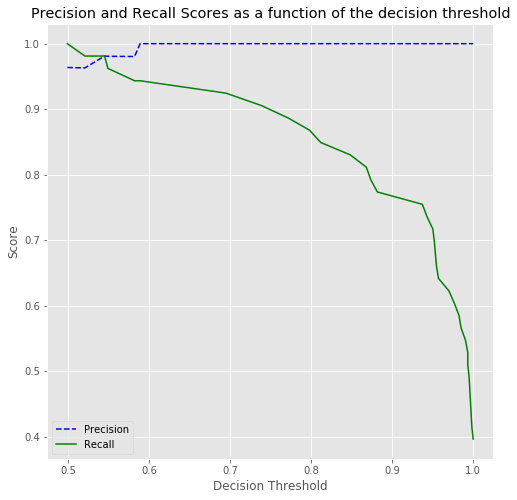

In [100]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

## Finally, the ROC curve shows that to achieve a 1.0 recall, the user of the model must select an operating point that allows for some false positive rate > 0.0.

In [127]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.99916142557652


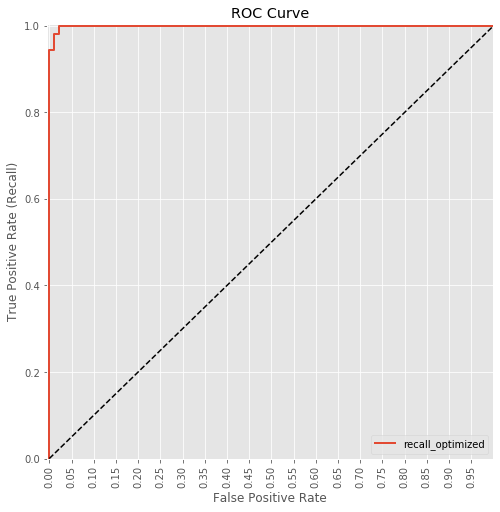

In [128]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')